## Import the useful library and the dataset

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_excel("../Datasets/Dry_Bean_Dataset.xlsx")
#df.head()

In [4]:
X = df.drop(columns=['Class']).values
y = df['Class'].values

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)


## Preprocess data by centering the variables and dividing them by their standard deviation.

In [5]:
# we use sklearn to prerocess
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(Xtrain)
#X_std.shape

## My algorithm to perform PCA

In [6]:
def my_PCA(X_std, k):
    """
    X: dataframe
        dataframe with n observation and p features, assumed to be already centered (nxp)
    k: int
        number of principal components we want to project on
    output: array-shape
        return the "projection matrix": this is a (p x k) matrix that is used to projecs a dataset of n observations and p features
        to a dataset with n observations and k feature; in particular, the "k most imporant" features of the initial dataset.
        (important according to "preserving varianca" paradigma)
        Remark:
        to actually projects, we have to compute the dot product between the initial nxp dataset and the output (pxk) matrix of this function my_PCA.
        Example:
        X = my_initial_nxp_dataset #assume X is centered
        find_best_k(X) #used to find the best k, call it k_bar
        proj_mtrx = my_PCA(X, k_bar)
        proj_dataset = X.dot(proj_mtrx) # this is the entire initial dataset projected onto the k PCs, so it is a nxk matrix.
    """
  
    cov_mat = np.cov(X_std.T)

    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    #print('eig_val:', eig_vals)
    #print('eig_vecs:', eig_vecs)

    sorted_indices = np.argsort(eig_vals)[::-1]
    sorted_eigvecs = eig_vecs[:,sorted_indices]
    #print('sorted_indeces:', sorted_indices)
    #print('sorted_eigvec:', sorted_eigvecs)
    

    #num_features = X_std.shape[1]
    #print(num_features)
    explained_variance_ratio = eig_vals / np.sum(eig_vals)
    fidelity_variance_ratio = np.cumsum(explained_variance_ratio)
    
    top_k_eigvecs = sorted_eigvecs[:k]
    #print(top_k_eigvecs.shape)
    #print('top_k:', top_k_eigvecs)

    #print('shape', top_k_eigvecs.T.shape)

    return top_k_eigvecs.T

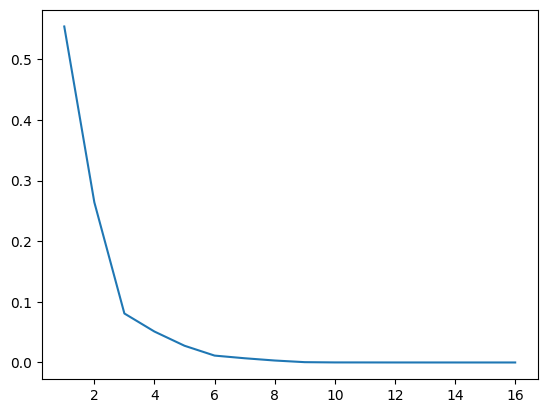

In [7]:
from matplotlib import pyplot as plt

def find_best_k(X_std):
    cov_mat = np.cov(X_std.T)

    eig_vals = np.linalg.eig(cov_mat)[0]

    lambdas = sorted(eig_vals, reverse=True)/np.sum(eig_vals)
    #print(lambdas)

    dim = [i for i in range(1,X_std.shape[1]+1)]

    plt.plot(dim, lambdas)


find_best_k(X_std)

In [8]:
"""
## check the leveles of y, and change it so that we can associate a color to each class
df['Class'].value_counts()

# create a dictionary to map categories to numbers
category_numbers = {category: num for num, category in enumerate(df['Class'].unique())}

# apply the mapping to the 'category' column using the map() function
df['Class'] = df['Class'].map(category_numbers)

y = df['Class'].values

"""

"\n## check the leveles of y, and change it so that we can associate a color to each class\ndf['Class'].value_counts()\n\n# create a dictionary to map categories to numbers\ncategory_numbers = {category: num for num, category in enumerate(df['Class'].unique())}\n\n# apply the mapping to the 'category' column using the map() function\ndf['Class'] = df['Class'].map(category_numbers)\n\ny = df['Class'].values\n\n"

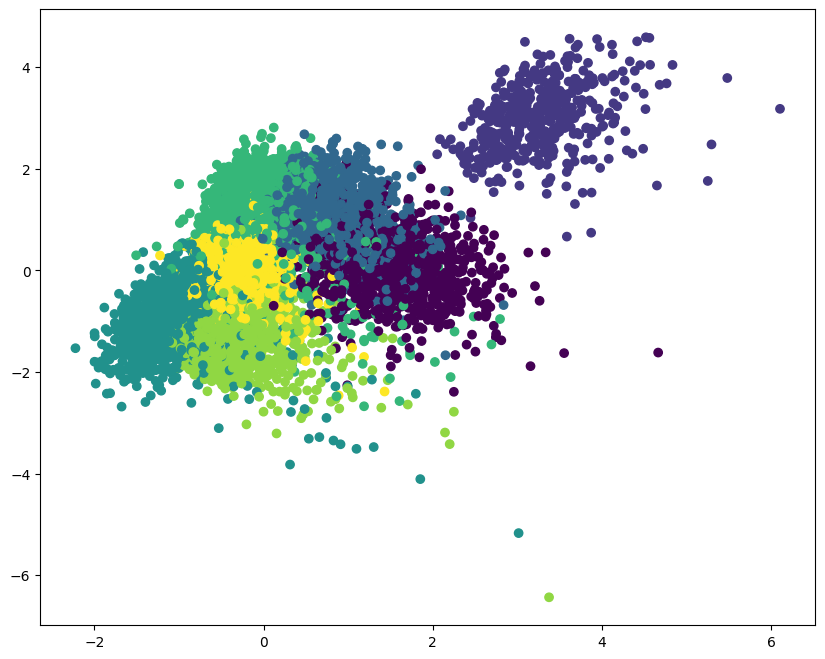

In [9]:
## Project the data (training set) in the first two principal components and color by class. Do it also for three principal components.
proj_to_2 = X_std.dot(my_PCA(X_std,2))

# proj_to_2  is the nx2 matrix with data that has 2 features. Its first column is the first component, and sec. col is sec comp.
# to extract the first datapoint, select the first row (which in this case has 2 element), and so noo for each datapoint
first_comp = [proj_to_2[i][0] for i in range(X_std.shape[0])]
second_comp = [proj_to_2[i][1] for i in range(X_std.shape[0])]

# Get the unique categories
unique_categories = np.unique(ytrain)

# Create an empty array to store the encoded values
encoded_array = np.empty_like(ytrain, dtype=int)

# Loop through each category and encode it
for i, category in enumerate(unique_categories):
    encoded_array[ytrain == category] = i

# apply the mapping to the 'category' column using the map() function
plt.figure(figsize=(10,8))
plt.scatter(first_comp,second_comp, c = encoded_array)



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:967: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


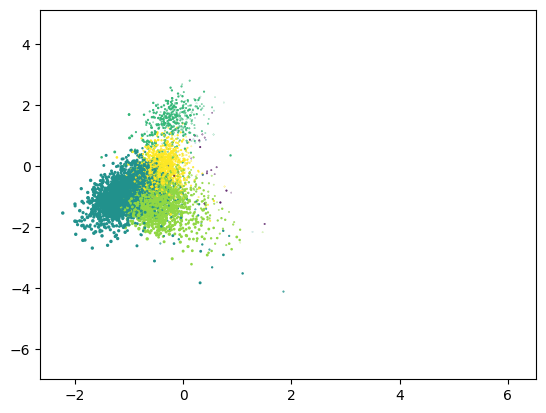

In [10]:
## Project the data (training set) in the first 3 principal components and color by class. Do it also for three principal components.
proj_to_3 = X_std.dot(my_PCA(X_std,3))

first_comp = [proj_to_3[i][0] for i in range(X_std.shape[0])]
second_comp = [proj_to_3[i][1] for i in range(X_std.shape[0])]
third_comp = [proj_to_3[i][2] for i in range(X_std.shape[0])]

# Get the unique categories
unique_categories = np.unique(ytrain)

# Create an empty array to store the encoded values
encoded_array = np.empty_like(ytrain, dtype=int)

# Loop through each category and encode it
for i, category in enumerate(unique_categories):
    encoded_array[ytrain == category] = i

plt.scatter(first_comp,second_comp, third_comp, c = encoded_array)

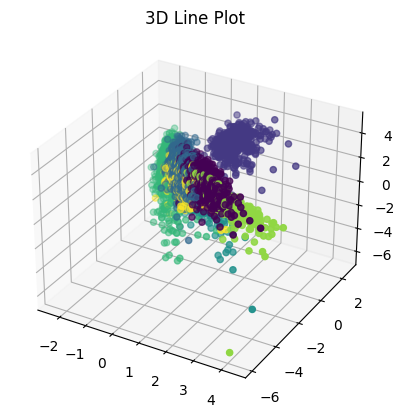

In [10]:
# create a 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Get the unique categories
unique_categories = np.unique(ytrain)

# Create an empty array to store the encoded values
encoded_array = np.empty_like(ytrain, dtype=int)

# Loop through each category and encode it
for i, category in enumerate(unique_categories):
    encoded_array[ytrain == category] = i

# plot the data
ax.scatter(first_comp, second_comp, third_comp, c = encoded_array)

# set the plot title and labels
ax.set_title('3D Line Plot')

# show the plot
plt.show()

In [11]:
# 3d interactive plot (can rotate the plot) with matplotlib

## For an increasing number of principal components (1 to 16):
    – apply a multinomial logistic regression to learn a model on the training set (use sklearn.linar model.LogisticRegression).

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for k in range(1,17):
    # Xtrain_proj is the train standardized dataset projected to k PC
    proj_mtrx = my_PCA(X_std, k)
    Xtrain_proj = X_std.dot(proj_mtrx)

    # fit a logistic regression using the dimension-reduced dataset Xtrain_proj (nxk instead of nxp, where p = 16)
    model = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
    model.fit(Xtrain_proj,ytrain)

    #transfrom the test set "Xtest" with proj_mtrx: 
        # we need to standardized Xtest too.    
    scaler = StandardScaler()
    X_std_test = scaler.fit_transform(Xtest)

    Xtest_proj = X_std_test.dot(proj_mtrx) # Xtest_proj is the test set transformed with the matrix learned in the training set, called proj_mtrx

    # Make a prediction with the logistic model learned.
    yhat = model.predict(Xtest_proj)

    # Assess the quality of the predictions
    acc = accuracy_score(ytest, yhat)
    print(f'Accuracy for {k} components: ', acc)
    

Accuracy for 1 components:  0.5152405435181785
Accuracy for 2 components:  0.61733382298935
Accuracy for 3 components:  0.7436650752846126
Accuracy for 4 components:  0.803892765332354
Accuracy for 5 components:  0.85200146896805
Accuracy for 6 components:  0.9122291590157914
Accuracy for 7 components:  0.9210429673154609
Accuracy for 8 components:  0.9210429673154609
Accuracy for 9 components:  0.9214102093279471
Accuracy for 10 components:  0.9221446933529196
Accuracy for 11 components:  0.9214102093279471
Accuracy for 12 components:  0.922879177377892
Accuracy for 13 components:  0.9221446933529196
Accuracy for 14 components:  0.9225119353654058
Accuracy for 15 components:  0.9221446933529196
Accuracy for 16 components:  0.922879177377892


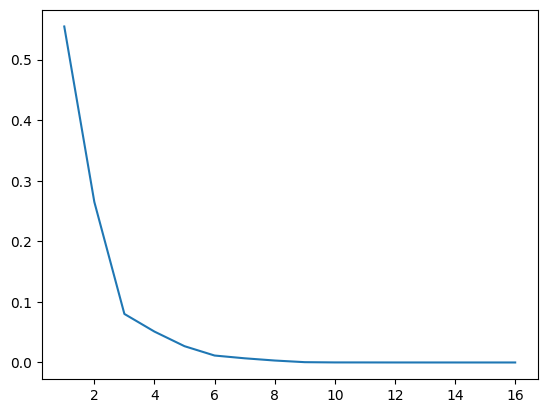

In [13]:
find_best_k(X_std) 


 si conferma che da 6 in giu, l accuracy non varia piu molto... infatti c'e un gomito a 3, ma poi un altro gomito a 6... dopo il 6, praticamente siamo stazionari

# Swiss Roll


Try to apply PCA to the Swiss Roll dataset (n = 1000) and plot the projection on the first two principal components. Choose an appropriate color scheme for visualization and comment on your results.

In [14]:
def swiss_roll(n):
    """
    Parameters:
    n: int
        Number of points to generate"""
    
    data = np.zeros((n,3))
    phi = np.random.uniform(low=1.5*np.pi, high=4.5*np.pi, size=n)
    psi = np.random.uniform(0,10,n)
            
    data[:,0]=phi*np.cos(phi) #x coordinte
    data[:,1]=phi*np.sin(phi) #y coordinate
    data[:,2]=psi #z coordinate
    return data

<class 'matplotlib.axes._subplots.Axes3DSubplot'>


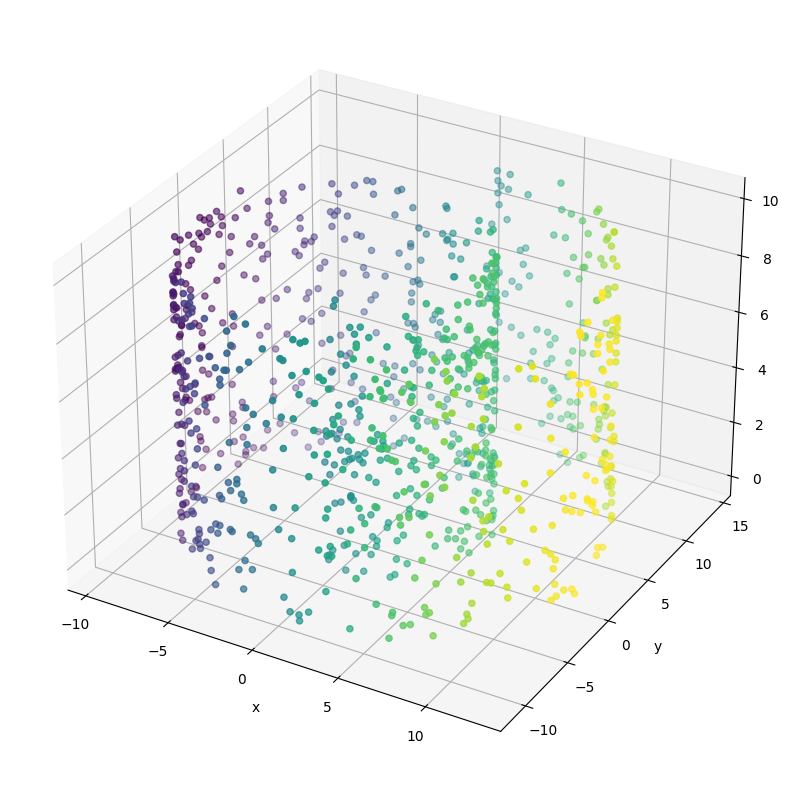

In [15]:
X = swiss_roll(1000)

plt.figure(figsize=(12,10))
axes = plt.axes(projection='3d')
print(type(axes))
axes.scatter3D(X[:,0], X[:,1], X[:,2], c=X[:,0])

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_zlabel('z')

#axes.view_init(45, 45) #(elevation, azimuth angle)

plt.show()

In [16]:
X.shape

(1000, 3)

In [18]:
X_std = X - X.mean(axis=0)
swiss_roll_proj = X_std.dot(my_PCA(X_std,2))

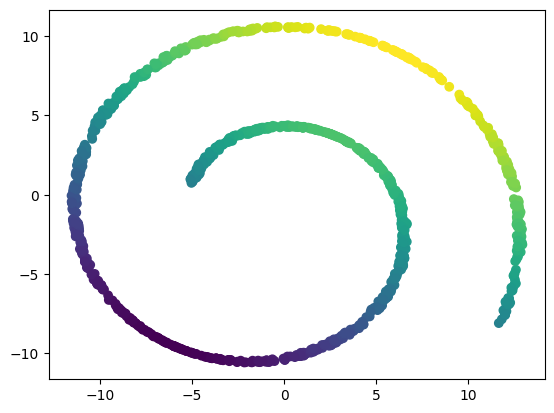

In [19]:
first_comp = [swiss_roll_proj[i][0] for i in range(X_std.shape[0])]
second_comp = [swiss_roll_proj[i][1] for i in range(X_std.shape[0])]

plt.scatter(first_comp, second_comp, c = X[:,0])

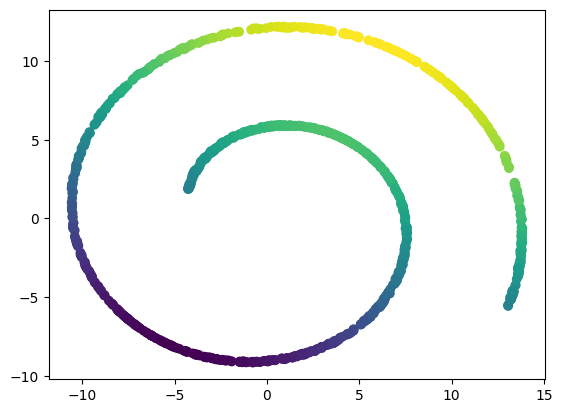

In [ ]:
# IF not STANDARDIZE
swiss_roll_proj = X.dot(my_PCA(X,2))
first_comp = [swiss_roll_proj[i][0] for i in range(X_std.shape[0])]
second_comp = [swiss_roll_proj[i][1] for i in range(X_std.shape[0])]

plt.scatter(first_comp, second_comp, c=X[:,0])